# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．

memo:<br>
MeCabは別途インストールしておくこと。

答え合わせはこのページを参考。<br>
[【言語処理100本ノック 2020】第4章: 形態素解析](https://qiita.com/yamaru/items/e06014b146a18e97ca59#comment-dbfb049b2ef950744cf9)

In [ ]:
! wget https://nlp100.github.io/data/neko.txt
! mecab neko.txt > neko.txt.mecab

In [1]:
MECAB_DIC = '/usr/local/lib/mecab/dic/mecab-ipadic-neologd'
INPUT_FILENAME = 'neko.txt'

## 30. 形態素解析結果の読み込み

形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

memo:<br>
dictなどマッピング型にすると

```python
word = morph.get('surface')
if morph.get('pos') == u'動詞':
    verb_word = word
...
```

というように、要素の値を参照する場合に格好が悪い。これを

```python
word = morph.surface
if morph.is_verb():
    verb_word = word
...
```

のように、クラスの属性やメソッドで参照するようにしたい。

以降の例では、後者のモデルで記載する。

In [2]:
import dataclasses
from typing import List
import MeCab


# 形態素クラス
# 後でsort対象として使うので、order=Trueにする
@dataclasses.dataclass(frozen=True, order=True)
class Morph:
    surface: str # 表層形
    base: str    # 基本形
    pos: str     # 品詞
    pos1: str    # 品詞際分類1
        
    def is_symbol(self):
        """記号判定
        """
        return self.pos == u'記号'

    def is_verb(self):
        """動詞判定
        """
        return self.pos == u'動詞'

    def is_noun(self):
        """名詞判定
        """
        return self.pos == u'名詞'

    def is_particle(self):
        """助詞判定
        """
        return self.pos == u'助詞'


# 文章情報クラス
@dataclasses.dataclass
class SentenceInfo:
    # 文章テキスト
    sentence: str
    # 分割された形態素リスト
    morphs: List[Morph] = dataclasses.field(default_factory=list)
        
    def get_surfaces(self):
        """表層形のリストを返す
        """
        return [m.surface for m in self.morphs]

    def get_bases(self):
        """基本形のリストを返す
        """
        return [m.base for m in self.morphs]


def analyze_text(filename):
    """テキストファイルを解析する
    テキストを文章に分解し、文章情報リストを返す
    """
    tagger = MeCab.Tagger(MECAB_DIC)

    with open(filename, 'r') as f:
        sentinfos = []
        for line in f.readlines():
            line = line.rstrip()
            # 空行はスキップ
            if not line: continue

            # 文章情報を作成
            sinfo = SentenceInfo(line)
            node = tagger.parseToNode(line)
            while node:
                if node.surface:
                    # 形態素を追加
                    detail = node.feature.split(',')
                    morph = Morph(node.surface, detail[6], detail[0], detail[1])
                    sinfo.morphs.append(morph)
                node = node.next
            sentinfos.append(sinfo)

        return sentinfos


# 最初の３つの文章解析結果を表示
sentinfos = analyze_text(INPUT_FILENAME)
print('total:', len(sentinfos)) # オリジナルテキストと同じ9964
for sinfo in sentinfos[:3]:
    print(sinfo.sentence)
    for morph in sinfo.morphs:
        print(morph)
    print()

total: 9210
一
Morph(surface='一', base='一', pos='名詞', pos1='数')

　吾輩は猫である。
Morph(surface='\u3000', base='\u3000', pos='記号', pos1='空白')
Morph(surface='吾輩', base='吾輩', pos='名詞', pos1='代名詞')
Morph(surface='は', base='は', pos='助詞', pos1='係助詞')
Morph(surface='猫', base='猫', pos='名詞', pos1='一般')
Morph(surface='で', base='だ', pos='助動詞', pos1='*')
Morph(surface='ある', base='ある', pos='助動詞', pos1='*')
Morph(surface='。', base='。', pos='記号', pos1='句点')

名前はまだ無い。
Morph(surface='名前', base='名前', pos='名詞', pos1='一般')
Morph(surface='は', base='は', pos='助詞', pos1='係助詞')
Morph(surface='まだ', base='まだ', pos='副詞', pos1='助詞類接続')
Morph(surface='無い', base='無い', pos='形容詞', pos1='自立')
Morph(surface='。', base='。', pos='記号', pos1='句点')



## 31. 動詞

動詞の表層形をすべて抽出せよ．

memo:<br>
表層形はsurfaceのこと。

In [3]:
def get_verb_surfaces(sentinfos):
    """文章情報リストから、動詞の表層形(surface)のリストを返す
    """
    verb_srfs = set()
    for sinfo in sentinfos:
        for m in sinfo.morphs:
            if m.is_verb(): # 動詞なら
                verb_srfs.add(m.surface)

    return list(verb_srfs)


# 動詞の表層形の合計と、先頭の５つを表示する
sentinfos = analyze_text(INPUT_FILENAME)
verbs = get_verb_surfaces(sentinfos)
print('total:', len(verbs))
for idx, v in enumerate(verbs[:5], start=1):
    print(f'{idx}:', v)

total: 3893
1: 仕り
2: 引き摺り込ま
3: 書き流し
4: 巡り
5: 動ずる


## 32. 動詞の原形

動詞の原形をすべて抽出せよ．

In [4]:
def get_verb_bases(sentinfos):
    """文章情報リストから、動詞の原型(base)のリストを返す
    """
    verb_bases = set()
    for sinfo in sentinfos:
        for m in sinfo.morphs:
            if m.is_verb(): # 動詞なら
                verb_bases.add(m.base)

    return list(verb_bases)


# 動詞の原型の合計と、先頭の５つを表示する
sentinfos = analyze_text(INPUT_FILENAME)
verbs = get_verb_bases(sentinfos)
print('total:', len(verbs))
for idx, v in enumerate(verbs[:5], start=1):
    print(f'{idx}:', v)

total: 2300
1: 倍する
2: 消え去る
3: 動ずる
4: うる
5: 書く


## 33. 「AのB」

2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [5]:
#
# 回答例１：文章ごとに組み合わせを取り出す
#
def get_A_no_B(sentinfos):
    """２つの名詞が「の」で連結されている名詞句を抽出する
    
    文章情報リストから、２つの名詞が「の」で連結されている文章テキストと、
    ２つの名詞で構成された計３つのテキストをタプルにし、そのリストを返す。
    """
    res = []
    for sinfo in sentinfos:
        ms = sinfo.morphs
        for i in range(len(ms)-2):
            if ms[i].is_noun() and ms[i+1].surface == u'の' and ms[i+2].is_noun():
                res.append((sinfo.sentence, ms[i].surface, ms[i+2].surface))

    return res


# ２つの名詞が「の」で連結されている名詞句の合計と、先頭の10例を表示
sentinfos = analyze_text(INPUT_FILENAME)
ab_pairs = get_A_no_B(sentinfos)
print('total:', len(ab_pairs))
for idx, (sent, a, b) in enumerate(ab_pairs[:10], start=1):
    print(f'{idx}:', sent.replace(f'{a}の{b}', f' **{a}の{b}** '))

total: 6044
1: ただ **彼の掌** に載せられてスーと持ち上げられた時何だかフワフワした感じがあったばかりである。
2:  **掌の上** で少し落ちついて書生の顔を見たのがいわゆる人間というものの見始であろう。
3: 掌の上で少し落ちついて **書生の顔** を見たのがいわゆる人間というものの見始であろう。
4: 第一毛をもって装飾されべき **はずの顔** がつるつるしてまるで薬缶だ。
5: のみならず **顔の真中** があまりに突起している。
6: そうしてその **穴の中** から時々ぷうぷうと煙を吹く。
7: 　この **書生の掌** の裏でしばらくはよい心持に坐っておったが、しばらくすると非常な速力で運転し始めた。
8: 　この書生の **掌の裏** でしばらくはよい心持に坐っておったが、しばらくすると非常な速力で運転し始めた。
9: それまでは記憶しているがあとは **何の事** やらいくら考え出そうとしても分らない。
10:  **肝心の母親** さえ姿を隠してしまった。


In [6]:
#
# 回答例２：全体からユニークな組み合わせを取り出す
#
def get_A_no_B_unique(sentinfos):
    """２つの名詞が「の」で連結されている名詞句を抽出する
    
    文章情報リストから、２つの名詞が「の」で連結されている２つの名詞の
    リストを返す。
    """
    res = set()
    for sinfo in sentinfos:
        ms = sinfo.morphs
        for i in range(len(ms)-2):
            if ms[i].is_noun() and ms[i+1].surface == u'の' and ms[i+2].is_noun():
                res.add((ms[i].surface, ms[i+2].surface))


    return list(res)


# ２つの名詞が「の」で連結されている名詞句の合計と、先頭の10例を表示
sentinfos = analyze_text(INPUT_FILENAME)
ab_pairs = get_A_no_B_unique(sentinfos)
print('total:', len(ab_pairs))
for idx, (a, b) in enumerate(ab_pairs[:10], start=1):
    print(f'{idx}:', f'{a}の{b}')

total: 4924
1: 時代の鉄
2: 小鼻の左右
3: 車屋のかみさん
4: 彼等の大胆
5: 蒲鉾の残り
6: 嬢のため
7: 種のダムダム弾
8: 枚の絵
9: ハリソンの歴史
10: 近来の名文


## 34. 名詞の連接

名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [7]:
def get_noun_sequence(sentinfos):
    """名詞の連接を抽出する
    
    文章情報リストから、文章と、連続する名詞のリストを返す。
    """
    res = []
    for sinfo in sentinfos:
        nouns = []      # 名詞リスト
        rsv_nouns = []  # 予約済み名詞リスト（これが出力される）
        for m in sinfo.morphs:
            if m.is_noun():
                # 名詞がきたら名詞リストに登録
                nouns.append(m.surface)
            else:
                # 名詞以外がきたら、名詞リストの内容を判定
                if len(nouns) <= 1:
                    # １名詞以下なら無視
                    pass
                elif not rsv_nouns:
                    # 予約済み名詞リストが空ならばセット
                    rsv_nouns = nouns
                elif len(nouns) > len(rsv_nouns):
                    # 予約済み名詞リストが名詞リストより少なければセット
                    rsv_nouns = nouns

                # 名詞リストをクリア
                if nouns: nouns = []
             
       # 名詞リストが残っている場合
        if len(nouns) > 1:
            if not rsv_nouns or len(nouns) > len(rsv_nouns):
                rsv_nouns = nouns
                
        # 予約済み名詞リストを登録
        if rsv_nouns:
            res.append((sinfo.sentence, rsv_nouns))

    return res

# 名詞の連接の合計と、対応する文章を10個表示する
sentinfos = analyze_text(INPUT_FILENAME)
noun_seqs = get_noun_sequence(sentinfos)
print('total:', len(noun_seqs))
for idx, (sent, nouns) in enumerate(noun_seqs[:10], start=1):
    print(f'{idx}:', sent.replace(f"{''.join(nouns)}", f" **{'+'.join(nouns)}** "))

total: 4478
1: しかもあとで聞くとそれは書生という **人間+中** で一番獰悪な種族であったそうだ。
2: この **時+妙** なものだと思った感じが今でも残っている。
3: 第 **一+毛** をもって装飾されべきはずの顔がつるつるしてまるで薬缶だ。
4:  **その後+猫** にもだいぶ逢ったがこんな片輪には一度も出会わした事がない。
5: そうしてその穴の中から時々 **ぷうぷうと+煙** を吹く。
6: ここへ這入ったら、どうにかなると思って竹垣の崩れた穴から、とある **邸+内** にもぐり込んだ。
7: この垣根の穴は今日に至るまで吾輩が隣家の **三+毛** を訪問する時の通路になっている。
8: ここで吾輩は彼の **書生+以外** の人間を再び見るべき機会に遭遇したのである。
9: 吾輩は投げ出されては這い上り、這い上っては投げ出され、何でも同じ事を **四+五+遍** 繰り返したのを記憶している。
10:  **この間+おさん** の三馬を偸んでこの返報をしてやってから、やっと胸の痞が下りた。


## 35. 単語の出現頻度

文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [8]:
from collections import defaultdict


def get_freq_word(sentinfos):
    """単語の形態素と出現頻度の辞書を返す
    """
    # こうしておくと、存在しないキーに対してインクリメントができる
    res = defaultdict(int)
    
    for sinfo in sentinfos:
        for m in sinfo.morphs:
            if m.is_symbol():
                # 記号はスキップ
                continue
            else:
                # キーを形態素にしてカウンタをインクリメント
                res[m.base] += 1

    # valueでソート
    res = sorted(res.items(), key=lambda x:x[1], reverse=True)

    return res

# 単語の出現頻度の上位10語を表示する
sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_word(sentinfos)
for idx, (word, num) in enumerate(agg[:10], start=1):
    print(f'{idx}:', word, num)

1: の 9194
2: て 6848
3: は 6420
4: に 6243
5: を 6071
6: だ 5975
7: と 5508
8: が 5337
9: た 4267
10: する 3657


## 36. 頻度上位10語

出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

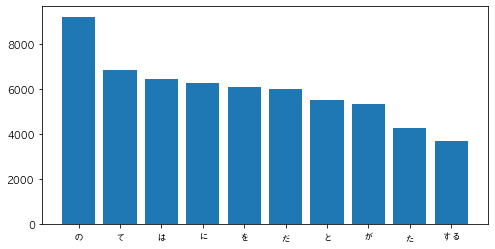

In [9]:
import matplotlib.pyplot as plt


def plot_frequency_ranking_graph(ranking_len, agg):
    """単語の形態素と出現頻度の辞書から、指定されたサイズのランキンググラフを表示
    """
    keys = [word for word, num in agg[:ranking_len]]
    values = [num for word, num in agg[:ranking_len]]
    plt.rcParams['font.family'] = 'AppleGothic'  # 日本語フォントを指定(macOS)
    plt.figure(figsize=(8, 4))
    plt.bar(keys, values)
    plt.show()


sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_word(sentinfos)

# 上位10語を棒グラフで表示
plot_frequency_ranking_graph(10, agg)

## 37. 「猫」と共起頻度の高い上位10語

「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

total: 1602
1: の 391
2: は 272
3: に 250
4: を 232
5: だ 231
6: て 229
7: と 202
8: が 180
9: する 144
10: た 140



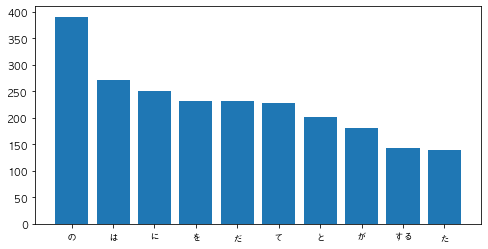

In [10]:
def get_freq_cooccur(word, sentinfos):
    """指定した単語と共起する単語と、その出現頻度を返す
    
    wordで指定した単語と共起する単語を、文章情報リストから取り出し、
    それらの出現頻度をカウントする。
    単語の形態素と出現頻度でtuppleを作り、そのリストを出現頻度で
    降順ソートして返す。
    """
    res = defaultdict(int)
    for sinfo in sentinfos:
        if word not in sinfo.get_bases():
            # wordが含まれていないならばスキップ
            continue

        for m in sinfo.morphs:
            if m.surface != word and not m.is_symbol():
                # wordそのものでなく、記号でないならインクリメント
                res[m.base] += 1
                
    # valueでreverseソート
    res = sorted(res.items(), key=lambda x:x[1], reverse=True)
    
    return res


# 「猫」と共起する単語の合計と、共起頻度の高い上位10語を表示
sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_cooccur(u'猫', sentinfos)
print('total:', len(agg))
for idx, (m, num) in enumerate(agg[:10], start=1):
    print(f'{idx}:', m, num)
print()

# 上位10語を棒グラフで表示
plot_frequency_ranking_graph(10, agg)

1: * 63
2: 事 59
3: 吾輩 58
4: の 55
5: 人間 40
6: もの 36
7: よう 34
8: 主人 22
9: 一 19
10: 人 19



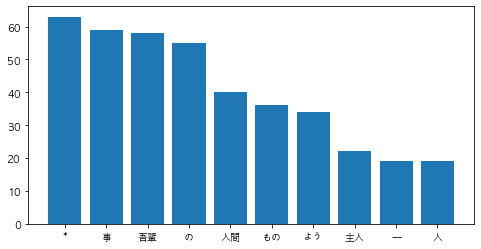

In [11]:
#
# 参考：「猫：と共振度の高い名詞
#

def get_freq_cooccur_noun(word, sentinfos):
    """指定した単語と共起する名詞と、その出現頻度を返す
    """
    res = defaultdict(int)
    for sinfo in sentinfos:
        if word not in sinfo.get_bases():
            # wordが含まれていないならばスキップ
            continue

        for m in sinfo.morphs:
            if m.base == word or m.is_symbol() or not m.is_noun():
                # wordそのものか、記号か、名詞でないならばスキップ
                continue

            res[m.base] += 1
                
    # valueでソート
    res = sorted(res.items(), key=lambda x:x[1], reverse=True)
    
    return res

# 「猫」と共起する名詞の合計と、共起頻度の高い上位10名詞を表示
sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_cooccur_noun(u'猫', sentinfos)
for idx, (base, num) in enumerate(agg[:10], start=1):
    print(f'{idx}:', base, num)
print()

# 上位10語を棒グラフで表示
plot_frequency_ranking_graph(10, agg)

# 注：
# 基本形"*"は分類できないものを指し、特定の基本形ではない

In [12]:
#
# 番外：「猫」＋「吾輩」の文を10例表示
#

def get_sents(sentinfos, words):
    """文章情報から、指定した単語を含む文のリストを返す
    """
    sents = []
    word_set = set(words)
    for sinfo in sentinfos:
        if word_set <= set(sinfo.get_bases()):
            sents.append(sinfo.sentence)

    return sents


# 「猫」と「吾輩」が含まれる文章を先頭から10だけ表示
sentinfos = analyze_text(INPUT_FILENAME)
sents = get_sents(sentinfos, (u'猫', u'吾輩'))
print('total:', len(sents))
for idx, sent in enumerate(sents[:10], start=1):
    print(f'{idx}:', sent.replace(u'猫', u' *猫* ').replace(u'吾輩', u' *吾輩* '))

total: 56
1: 　 *吾輩* は *猫* である。
2: 下女は *吾輩* をぶら下げて主人の方へ向けてこの宿なしの小 *猫* がいくら出しても出しても御台所へ上って来て困りますという。
3:  *吾輩* は *猫* ながら時々考える事がある。
4:  *吾輩* は *猫* として決して上乗の出来ではない。
5:  *吾輩* は波斯産の *猫* のごとく黄を含める淡灰色に漆のごとき斑入りの皮膚を有している。
6: しかし挨拶をしないと険呑だと思ったから「 *吾輩* は *猫* である。
7: 　 *吾輩* は新年来多少有名になったので、 *猫* ながらちょっと鼻が高く感ぜらるるのはありがたい。
8: 少し眼識のあるものなら、 *猫* の中でも他の *猫* じゃない *吾輩* である事が判然とわかるように立派に描いてある。
9:  *吾輩* であると云う事はよし分らないにしても、せめて *猫* であるという事だけは分らしてやりたい。
10: しかし人間というものは到底 *吾輩*  *猫* 属の言語を解し得るくらいに天の恵に浴しておらん動物であるから、残念ながらそのままにしておいた。


## 38. ヒストグラム

単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．

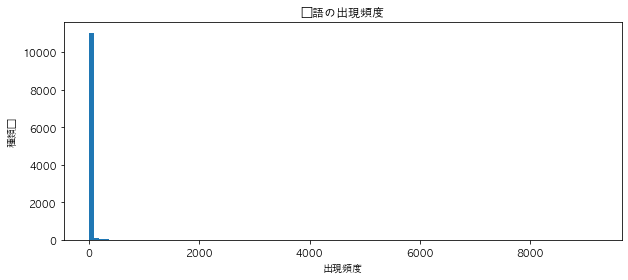

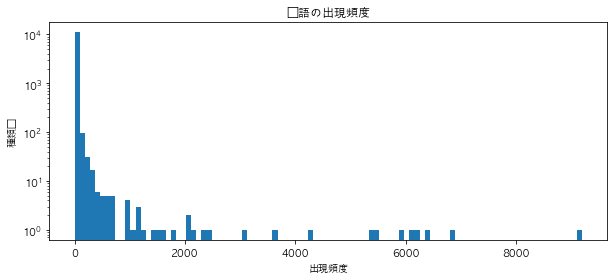

In [14]:
def plot_histogram(agg, title, ylog=False):
    """ヒストグラムを表示する
    """
    values = [num for word, num in agg]
    plt.rcParams['font.family'] = 'AppleGothic'  # 日本語フォントを指定(macOS)
    plt.figure(figsize=(10, 4))
    plt.hist(values, bins=100)
    plt.title(title)
    if ylog:
        plt.yscale('log')
    plt.xlabel(u'出現頻度')
    plt.ylabel(u'種類数')
    plt.show()


# 単語の出現頻度のヒストグラムを表示する
sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_word(sentinfos)
plot_histogram(agg, u'単語の出現頻度')

# Y軸を対数にして表示
plot_histogram(agg, u'単語の出現頻度', ylog=True)

## 39. Zipfの法則

単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

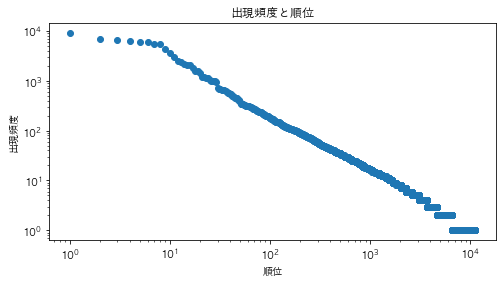

In [15]:
def plot_zipf(agg, title):
    ranks = [r+1 for r in range(len(agg))]
    values = [num for word, num in agg]
    plt.rcParams['font.family'] = 'AppleGothic'  # 日本語フォントを指定(macOS)
    plt.figure(figsize=(8, 4))
    plt.scatter(ranks, values)
    plt.title(title)
    plt.xlabel(u'順位')
    plt.ylabel(u'出現頻度')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

sentinfos = analyze_text(INPUT_FILENAME)
agg = get_freq_word(sentinfos)
plot_zipf(agg, '出現頻度と順位')